/var/folders/ml/69jz_hln1nv6px47r10h6ccm0000gn/T/ipykernel_24352/3198267742.py:7: DtypeWarning: Columns (19,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/lightcast_job_postings.csv")


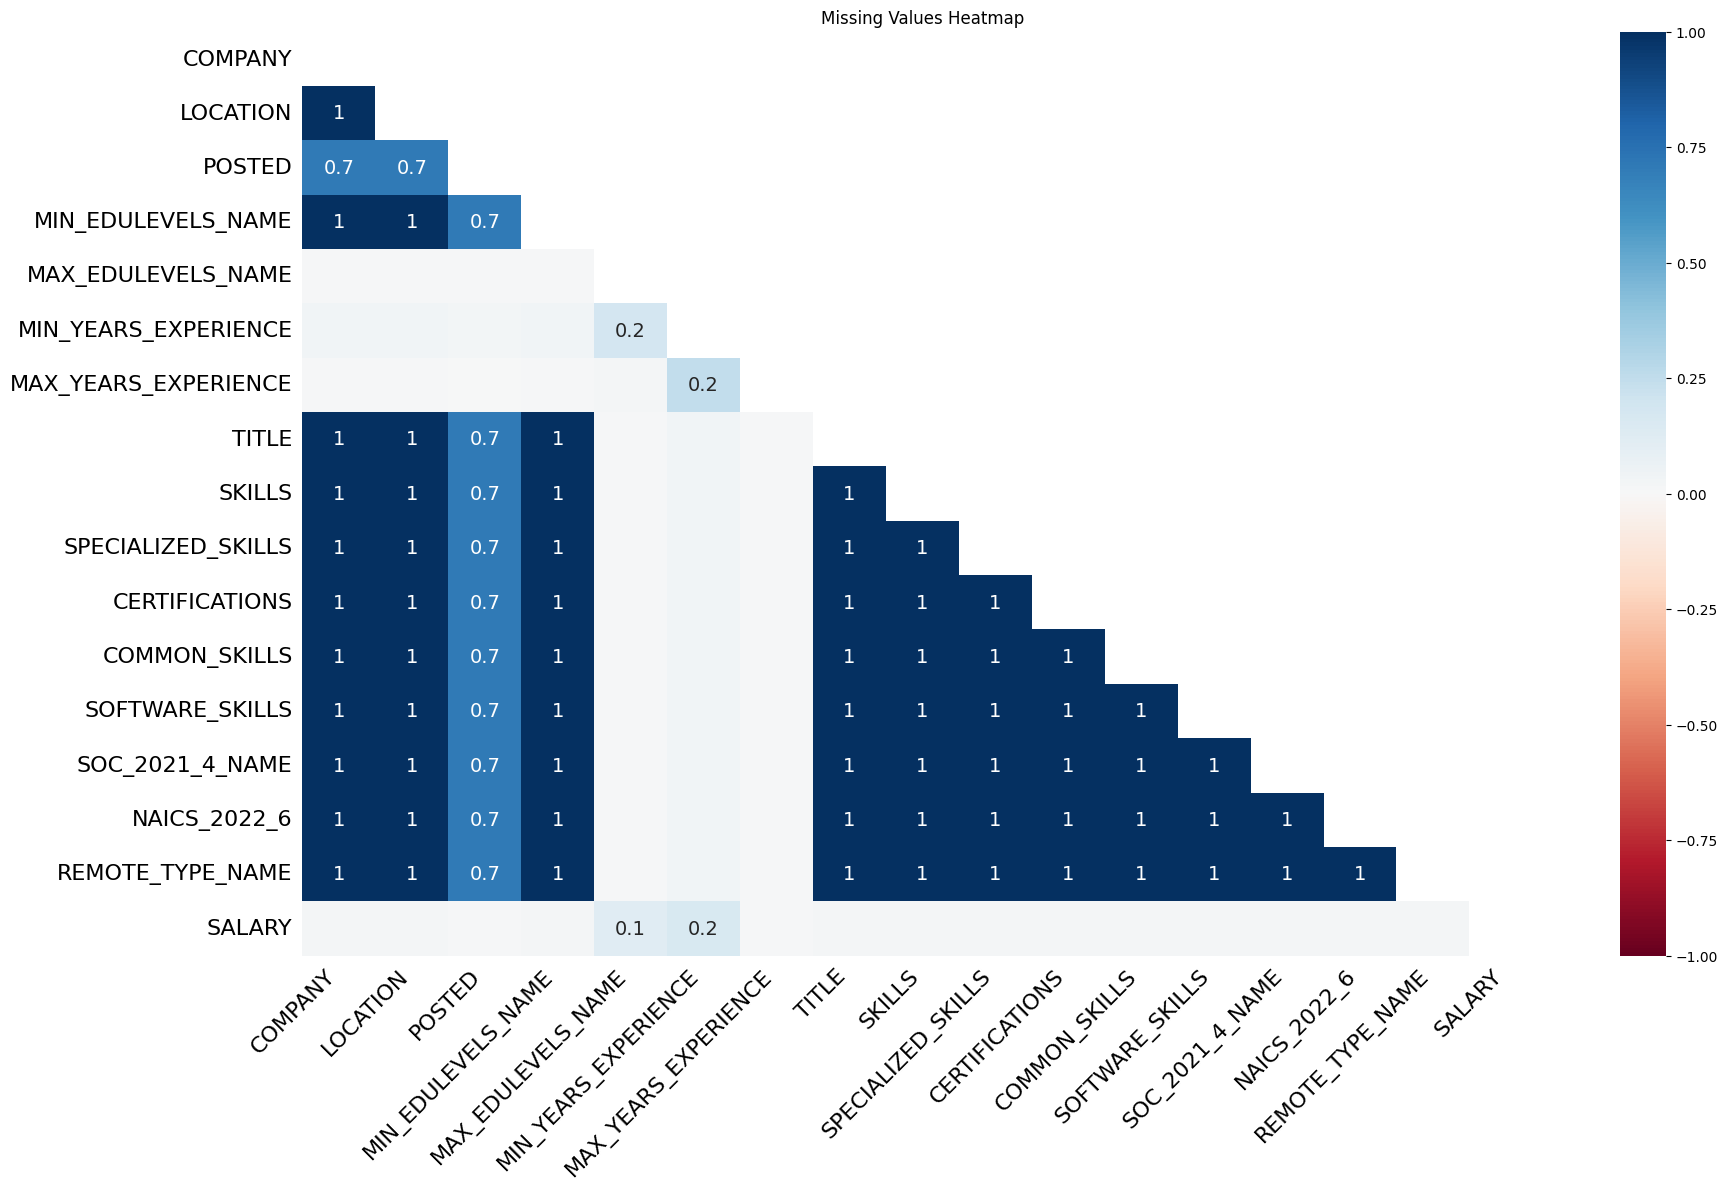

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import missingno as msno

df = pd.read_csv("data/lightcast_job_postings.csv")

columns_to_keep = [
    'COMPANY',  
    'LOCATION',
    'POSTED',              
    'MIN_EDULEVELS_NAME',   
    'MAX_EDULEVELS_NAME',       
    'MIN_YEARS_EXPERIENCE',
    'MAX_YEARS_EXPERIENCE',        
    'TITLE',               
    'SKILLS',                     
    'SPECIALIZED_SKILLS',       
    'CERTIFICATIONS',           
    'COMMON_SKILLS',            
    'SOFTWARE_SKILLS',        
    'SOC_2021_4_NAME',           
    'NAICS_2022_6',              
    'REMOTE_TYPE_NAME',          
    'SALARY',              
]
df = df[columns_to_keep]

msno.heatmap(df)
plt.title("Missing Values Heatmap")
plt.show()

In [4]:

if "SALARY" in df.columns:
    df["SALARY"].fillna(df["SALARY"].median(), inplace=True)
else:
    print("⚠️ Warning: 'SALARY' column not found in dataframe!")

if "COMPANY" in df.columns:
    df["COMPANY"].fillna("Unknown", inplace=True)
else:
    print("⚠️ Warning: 'COMPANY' column not found in dataframe!")

    # Fill numeric columns with mean
num_cols = df.select_dtypes(include='number').columns
for col in num_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].mean(), inplace=True)

# Fill categorical columns with mode
cat_cols = df.select_dtypes(include='object').columns
for col in cat_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].mode()[0], inplace=True)

print("✅ Remaining missing values filled based on column type.")


df.dropna(thresh=len(df) * 0.5, axis=1, inplace=True)


print("✅ Missing value handling complete.")

# delete duplicates
df = df.drop_duplicates(subset=["TITLE", "COMPANY", "LOCATION", "POSTED"])

print(df.isnull().sum())

/var/folders/ml/69jz_hln1nv6px47r10h6ccm0000gn/T/ipykernel_24352/3285024803.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["SALARY"].fillna(df["SALARY"].median(), inplace=True)
/var/folders/ml/69jz_hln1nv6px47r10h6ccm0000gn/T/ipykernel_24352/3285024803.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting val

✅ Remaining missing values filled based on column type.
✅ Missing value handling complete.
COMPANY                 0
LOCATION                0
POSTED                  0
MIN_EDULEVELS_NAME      0
MAX_EDULEVELS_NAME      0
MIN_YEARS_EXPERIENCE    0
MAX_YEARS_EXPERIENCE    0
TITLE                   0
SKILLS                  0
SPECIALIZED_SKILLS      0
CERTIFICATIONS          0
COMMON_SKILLS           0
SOFTWARE_SKILLS         0
SOC_2021_4_NAME         0
NAICS_2022_6            0
REMOTE_TYPE_NAME        0
SALARY                  0
dtype: int64


In [8]:
df['SPECIALIZED_SKILLS ']

KeyError: 'SPECIALIZED_SKILLS '

In [11]:
df['SKILLS_NAME'].head()


KeyError: 'SKILLS_NAME'